# Import and Install Dependencies

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from math import exp
import mediapipe as mp
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [2]:
initial_learning_rate=0.1
batch_size=32
path="C:\\Users\\ganga\Jupyter Notebook\\FINAL YEAR PROJECT\\"

# Keypoints using MP Holistic

In [3]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [5]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [6]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

# Extract Keypoint Values

In [7]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# Setup Folders for Collection

In [8]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thank you', 'eat'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'hello': 0, 'thank you': 1, 'eat': 2}

# Preprocess Data and Create Labels and Features

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [10]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [11]:
np.array(os.listdir(os.path.join(DATA_PATH, action)))

array(['20221218173741482468', '20221218173741591177',
       '20221218173741700884', '20221218173741810590',
       '20221218173741920951', '20221218173742032084',
       '20221218173742141791', '20221218173742253492',
       '20221218173742361205', '20221218173742470911',
       '20221218173742579621', '20221218173742688330',
       '20221218173742800067', '20221218173742909772',
       '20221218173743021488', '20221218173743133193',
       '20221218173743241885', '20221218173743351591',
       '20221218173743462310', '20221218173743572965',
       '20221218173743684702', '20221218173743793642',
       '20221218173743902392', '20221218173744010961',
       '20221218173744119756', '20221218173744228736',
       '20221218173744337840', '20221218173744446106',
       '20221218173744553699', '20221218173825624669',
       '20221219192510952602', '20221219192511060150',
       '20221219192511169248', '20221219192511276366',
       '20221219192511385989', '20221219192511495753',
       '20

In [12]:
np.array(sequences).shape

(270, 30, 1662)

In [13]:
np.array(labels).shape

(270,)

In [14]:
X = np.array(sequences)

In [15]:
X.shape

(270, 30, 1662)

In [16]:
y = to_categorical(labels).astype(int)

In [17]:
y[:5]

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,shuffle=True)

In [19]:
y_test.shape

(27, 3)

# Build and Train LSTM Neural Network

In [20]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [21]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))#kernel_regularizer=regularizers.l2(0.005),
model.add(LSTM(128, return_sequences=True, activation='relu'))#kernel_regularizer=regularizers.l2(0.005),
model.add(LSTM(64, return_sequences=False, activation='relu'))#kernel_regularizer=regularizers.l2(0.005),
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-trai

## 1

In [22]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [140]:
model.fit(X_train, y_train, epochs=25, callbacks=[tb_callback],shuffle=True)

Epoch 1/25
8/8 [==============================] - 3s 127ms/step - loss: 0.2271 - categorical_accuracy: 0.9095
Epoch 2/25
8/8 [==============================] - 1s 127ms/step - loss: 0.1734 - categorical_accuracy: 0.9342
Epoch 3/25
8/8 [==============================] - 1s 126ms/step - loss: 0.1231 - categorical_accuracy: 0.9588
Epoch 4/25
8/8 [==============================] - 1s 126ms/step - loss: 0.1613 - categorical_accuracy: 0.9383
Epoch 5/25
8/8 [==============================] - 1s 125ms/step - loss: 0.1616 - categorical_accuracy: 0.9095
Epoch 6/25
8/8 [==============================] - 1s 126ms/step - loss: 0.3163 - categorical_accuracy: 0.8971
Epoch 7/25
8/8 [==============================] - 1s 125ms/step - loss: 0.3300 - categorical_accuracy: 0.8560
Epoch 8/25
8/8 [==============================] - 1s 125ms/step - loss: 0.2306 - categorical_accuracy: 0.8889
Epoch 9/25
8/8 [==============================] - 1s 126ms/step - loss: 0.1788 - categorical_accuracy: 0.9424
Epoch 10/2

## 2

## 3

# Evaluation using Confusion Matrix and Accuracy

In [141]:
ypred = model.predict(X_test)

1/1 [==============================] - 0s 71ms/step


In [142]:
ypred

array([[9.01127078e-06, 9.89656329e-01, 1.03347497e-02],
       [3.01692980e-05, 7.65526772e-01, 2.34443039e-01],
       [4.21735240e-06, 9.45881844e-01, 5.41139953e-02],
       [1.65868551e-02, 2.27758451e-03, 9.81135547e-01],
       [2.74506783e-06, 8.97283077e-01, 1.02714166e-01],
       [2.37001199e-03, 1.53021682e-02, 9.82327819e-01],
       [9.99960303e-01, 1.10590319e-08, 3.96868163e-05],
       [8.45011255e-06, 9.81191337e-01, 1.88002568e-02],
       [3.60976355e-06, 9.94607031e-01, 5.38946688e-03],
       [5.36004791e-06, 9.96758878e-01, 3.23582627e-03],
       [1.84406326e-06, 9.91684198e-01, 8.31386726e-03],
       [3.13446787e-03, 4.85843373e-03, 9.92007017e-01],
       [7.03094702e-06, 9.93472874e-01, 6.52005337e-03],
       [9.99992847e-01, 7.27503446e-10, 7.12580413e-06],
       [1.14819222e-05, 9.76918876e-01, 2.30695605e-02],
       [1.75015570e-03, 1.90788023e-02, 9.79171038e-01],
       [1.20921295e-05, 6.82092488e-01, 3.17895353e-01],
       [2.29648504e-05, 9.37758

In [143]:
ytrue = np.argmax(y_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()

In [144]:
multilabel_confusion_matrix(ytrue, ypred)

array([[[22,  0],
        [ 0,  5]],

       [[13,  2],
        [ 1, 11]],

       [[16,  1],
        [ 2,  8]]], dtype=int64)

In [145]:
accuracy_score(ytrue, ypred)

0.8888888888888888

# Make Predictions

In [127]:
res = model.predict(X_test)

1/1 [==============================] - 0s 55ms/step


In [128]:
res

array([[2.82210967e-05, 9.75905001e-01, 2.40667127e-02],
       [2.91979196e-03, 3.38492244e-01, 6.58587992e-01],
       [6.19166880e-04, 6.61247015e-01, 3.38133812e-01],
       [4.80218142e-01, 3.35604721e-03, 5.16425729e-01],
       [5.40403607e-06, 9.67904985e-01, 3.20895724e-02],
       [5.38606532e-02, 9.06337332e-03, 9.37076032e-01],
       [9.99878407e-01, 1.02816877e-07, 1.21432626e-04],
       [1.39098105e-04, 8.36965144e-01, 1.62895739e-01],
       [6.76372565e-06, 9.93321598e-01, 6.67166989e-03],
       [5.71904877e-07, 9.99774158e-01, 2.25275275e-04],
       [1.14012869e-06, 9.99269426e-01, 7.29422551e-04],
       [1.71989296e-02, 1.08329933e-02, 9.71968055e-01],
       [1.15579942e-05, 9.91538048e-01, 8.45039450e-03],
       [9.99969482e-01, 9.39645783e-09, 3.04635068e-05],
       [4.06219420e-04, 9.98842418e-01, 7.51282438e-04],
       [3.23444866e-02, 9.80887655e-03, 9.57846642e-01],
       [2.81300854e-05, 9.14749026e-01, 8.52228105e-02],
       [1.55292058e-04, 9.28454

In [129]:
actions[np.argmax(res[4])]

'thank you'

In [130]:
actions[np.argmax(y_test[4])]

'thank you'

# Save Weights

In [131]:
model.save('action.h5')

In [132]:
from tensorflow.keras.models import load_model
model = load_model("action.h5")

In [133]:
test_DATA_PATH='MP_Data_gangadhar_v2'
sequences_test, labels_test = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(test_DATA_PATH, action))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(test_DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_test.append(window)
        labels_test.append(label_map[action])
sequences_test=np.array(sequences_test)
labels_test = to_categorical(labels_test).astype(int)
ypred = model.predict(sequences_test)
ytrue = np.argmax(labels_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()
accuracy_score(ytrue, ypred)

3/3 [==============================] - 0s 38ms/step


1.0

In [134]:
test_DATA_PATH='MP_Data_jagadesh'
sequences_test, labels_test = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(test_DATA_PATH, action))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(test_DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_test.append(window)
        labels_test.append(label_map[action])
sequences_test=np.array(sequences_test)
labels_test = to_categorical(labels_test).astype(int)
ypred = model.predict(sequences_test)
ytrue = np.argmax(labels_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()
accuracy_score(ytrue, ypred)

3/3 [==============================] - 0s 38ms/step


0.8888888888888888

In [135]:
test_DATA_PATH='MP_Data_venky'
sequences_test, labels_test = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(test_DATA_PATH, action))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(test_DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_test.append(window)
        labels_test.append(label_map[action])
sequences_test=np.array(sequences_test)
labels_test = to_categorical(labels_test).astype(int)
ypred = model.predict(sequences_test)
ytrue = np.argmax(labels_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()
accuracy_score(ytrue, ypred)

3/3 [==============================] - 0s 36ms/step


0.8888888888888888

# Test in Real Time

In [29]:
from tensorflow.keras.models import load_model
model = load_model("SignModV1.h5")

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 596,708
Trainable params: 596,708
Non-trai

In [21]:
from scipy import stats

In [22]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [23]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.9, min_tracking_confidence=0.9) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

1/1 [==============================] - 1s 683ms/step
hello
1/1 [==============================] - 0s 38ms/step
hello
1/1 [==============================] - 0s 35ms/step
hello
1/1 [==============================] - 0s 36ms/step
hello
1/1 [==============================] - 0s 35ms/step
hello
1/1 [==============================] - 0s 34ms/step
hello
1/1 [==============================] - 0s 36ms/step
hello
1/1 [==============================] - 0s 51ms/step
hello
1/1 [==============================] - 0s 41ms/step
hello
1/1 [==============================] - 0s 44ms/step
hello
1/1 [==============================] - 0s 42ms/step
hello
1/1 [==============================] - 0s 43ms/step
hello
1/1 [==============================] - 0s 34ms/step
hello
1/1 [==============================] - 0s 35ms/step
hello
1/1 [==============================] - 0s 32ms/step
hello
1/1 [==============================] - 0s 33ms/step
hello
1/1 [==============================] - 0s 33ms/step
hello
1/1 [========

1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 36ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 33ms/step
eat
1/1 [==============================] - 0s 30ms/s

1/1 [==============================] - 0s 28ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 33ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 28ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 33ms/step
eat
1/1 [==============================] - 0s 33ms/step
eat
1/1 [==============================] - 0s 30ms/s

1/1 [==============================] - 0s 33ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 34ms/step
eat
1/1 [==============================] - 0s 28ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 29ms/s

1/1 [==============================] - 0s 34ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 37ms/step
eat
1/1 [==============================] - 0s 40ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 33ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 33ms/step
eat
1/1 [==============================] - 0s 36ms/s

1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 33ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 32ms/s

1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 33ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 28ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/s

1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 33ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 41ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 29ms/s

1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 34ms/step
eat
1/1 [==============================] - 0s 34ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 34ms/s

1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/s

1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/s

1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 34ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 33ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/s

1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 33ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 29ms/s

1/1 [==============================] - 0s 33ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 37ms/step
eat
1/1 [==============================] - 0s 37ms/step
eat
1/1 [==============================] - 0s 38ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 32ms/s

1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 28ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 28ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 32ms/s

1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 28ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 31ms/s

1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 39ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 38ms/step
eat
1/1 [==============================] - 0s 36ms/step
eat
1/1 [==============================] - 0s 39ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 29ms/s

1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 43ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 33ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/s

1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 33ms/step
eat
1/1 [==============================] - 0s 33ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 34ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 35ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 37ms/step
eat
1/1 [==============================] - 0s 46ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 33ms/step
eat
1/1 [==============================] - 0s 29ms/s

1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 33ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 33ms/step
eat
1/1 [==============================] - 0s 34ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/s

1/1 [==============================] - 0s 38ms/step
thank you
1/1 [==============================] - 0s 45ms/step
thank you
1/1 [==============================] - 0s 29ms/step
thank you
1/1 [==============================] - 0s 35ms/step
thank you
1/1 [==============================] - 0s 28ms/step
thank you
1/1 [==============================] - 0s 31ms/step
thank you
1/1 [==============================] - 0s 30ms/step
thank you
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 31ms/step
thank you
1/1 [==============================] - 0s 30ms/step
thank you
1/1 [==============================] - 0s 34ms/step
thank you
1/1 [==============================] - 0s 31ms/step
thank you
1/1 [==============================] - 0s 31ms/step
thank you
1/1 [==============================] - 0s 31ms/step
thank you
1/1 [==============================] - 0s 37ms/step
thank you
1/1 [==============================] - 0s 32ms/step
thank you
1/1 [=========

1/1 [==============================] - 0s 31ms/step
thank you
1/1 [==============================] - 0s 30ms/step
thank you
1/1 [==============================] - 0s 31ms/step
thank you
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 33ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 32ms/step
eat
1/1 [==============================] - 0s 29ms/step
eat
1/1 [==============================] - 0s 31ms/step
eat
1/1 [==============================] - 0s 30ms/step
eat
1/1 [==============================] - 0s 33ms/step
hello
1/1 [==============================] - 0s 30ms/step
hello
1/1 [==============================] - 0s 30ms/step
hello
1/1 [===================

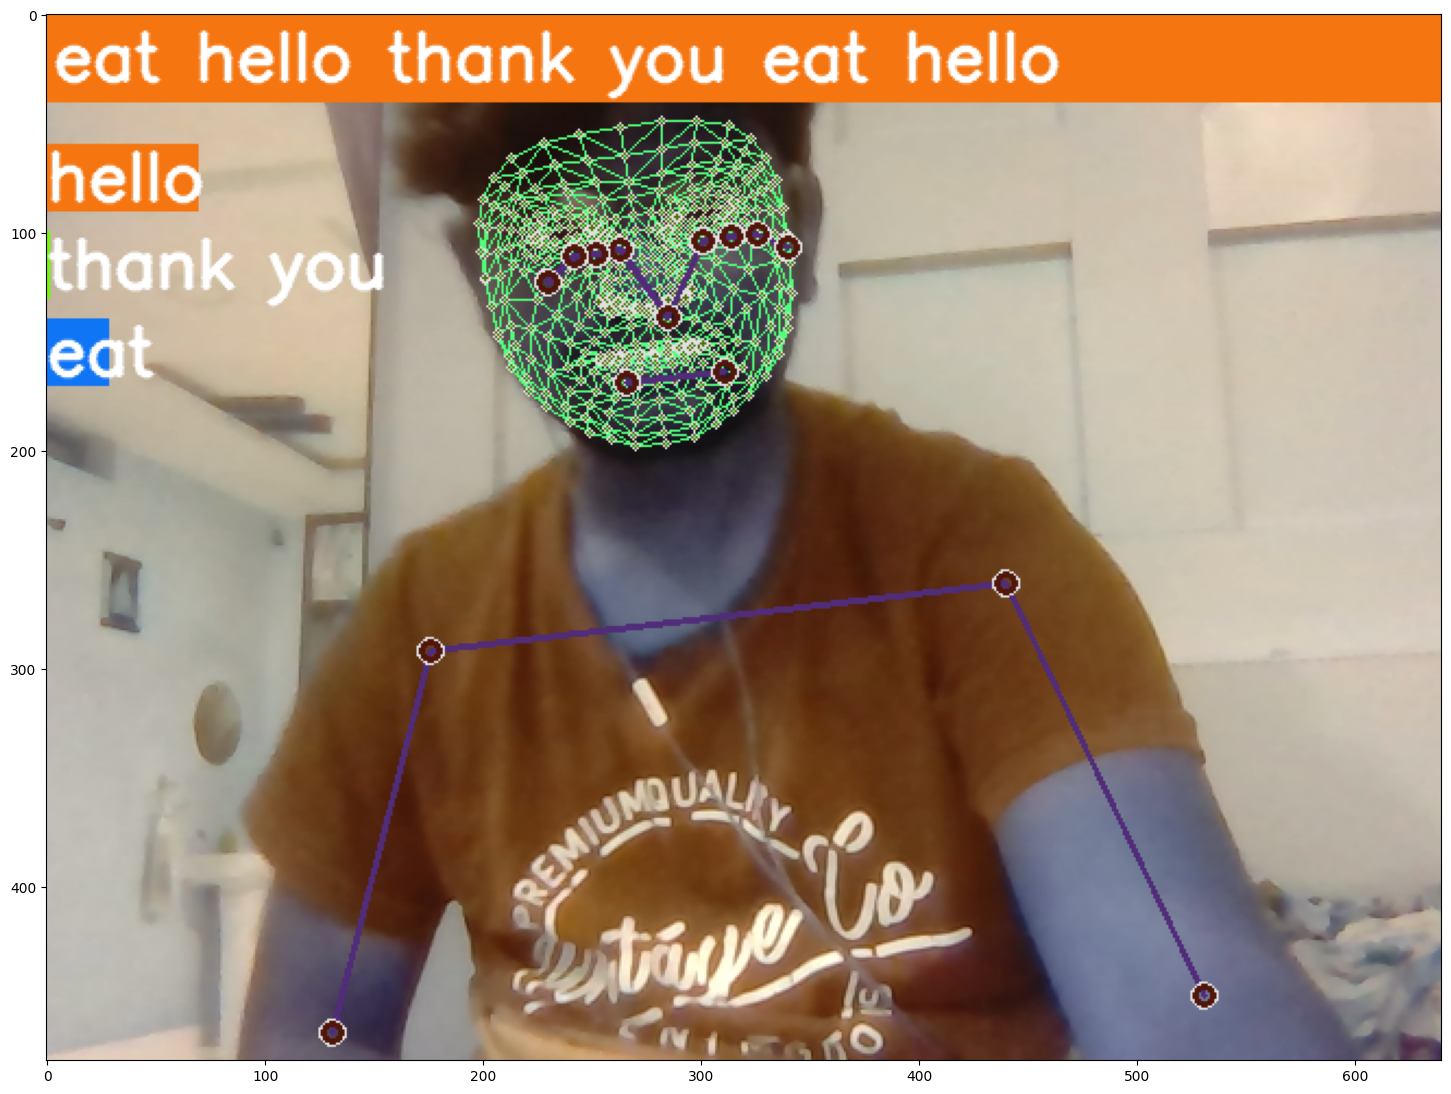

In [24]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))